In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# загрузка и предобработка
import pandas as pd 
import numpy as np
import seaborn as sns
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

# https://github.com/huggingface/transformers
# обучение, загрузка по формату библиотеки, оптимизаторы
# !pip install transformers
# !pip install datasets
# !pip install umap-learn
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
# обучение
import torch
from torch.utils.data import DataLoader
# предобработка и финальный отчет по метрикам
from sklearn import preprocessing
from sklearn.metrics import classification_report
# кластеризация
from sklearn.feature_extraction.text import CountVectorizer
import umap
from sklearn.cluster import DBSCAN
# прогресс бар
from tqdm import tqdm
# очистка кешей
import gc
# размер шрифта в графиках
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [ ]:
df_old = pd.read_csv('tech-requests-analysis\cleared.csv')
df = pd.read_csv('data_df.csv')

In [ ]:
df_old[['description', 'team_direct']]

,description,team_direct
0,"сим-карты получены В данный момент, запросил д...",Disp
1,Гарнитура предоставлена Здравствуйте. Прошу пр...,IT
2,Доступ в продуктивную базу SAP Прошу дать дост...,Access
3,Программа загрузки ОЗМ скорректирована. Поиск ...,MDM
4,Учетная запись создана: r.skorkin@agroinvest.c...,IT
...,...,...
44903,Не найден 83ДРС с ФП= G210090000 для даты 09.0...,DMS
44904,при выводе на печать документов выходит сообще...,Disp
44905,Добрый день! При фактурировании исходящей пос...,Disp
44906,Добрый день! Документы внесены. Добавление дов...,DMS


In [ ]:
df[['description', 'team_direct']]

,description,team_direct
0,"Добрый день! При создании, в момент проводки ...",FI_FM
1,Налоговая карточка открыта. Задача не отдела Н...,FI_FM
2,Добрый день! Данные внесены.,MDM
3,Добавлено права доступа в САП Прошу предостави...,Access
4,Добавлено добавить права к существующим транза...,Access
...,...,...
21302,оплата пайщикам ФИО*: Шевцова Марина Владимиро...,RE_FX
21303,"Добрый день, прошу выслать Логин и пароль САП ...",Access
21304,Прошу выслать актуальный пароль СМД [https:/...,Access
21305,Согласовано Добрый день! Просим согласовать з...,MDM


In [ ]:
df = pd.concat([df_old[['description', 'team_direct']], df[['description', 'team_direct']]])
df

,description,team_direct
0,"сим-карты получены В данный момент, запросил д...",Disp
1,Гарнитура предоставлена Здравствуйте. Прошу пр...,IT
2,Доступ в продуктивную базу SAP Прошу дать дост...,Access
3,Программа загрузки ОЗМ скорректирована. Поиск ...,MDM
4,Учетная запись создана: r.skorkin@agroinvest.c...,IT
...,...,...
21302,оплата пайщикам ФИО*: Шевцова Марина Владимиро...,RE_FX
21303,"Добрый день, прошу выслать Логин и пароль САП ...",Access
21304,Прошу выслать актуальный пароль СМД [https:/...,Access
21305,Согласовано Добрый день! Просим согласовать з...,MDM


In [ ]:
df.team_direct.value_counts()

MDM            22526
IT             10270
Access          6671
FI_FM           5056
HCM             4783
Disp            2830
MM              2468
DMS             2389
ITTelematic     1486
ARM             1385
PP              1348
MM_SD            890
Directum         806
PM               711
RE_FX            678
1C               629
Novatech         519
SD               295
CO               261
PS                96
BC                43
FI_MSFO           40
FI_AA             29
Office             4
Print              1
ALL                1
Name: team_direct, dtype: int64

In [ ]:
# удаляем команды описанные малым числом примеров (>min_req)
min_req = 100

filtered_classes = df.team_direct.value_counts()[df.team_direct.value_counts() > min_req].index.values

df = df[df.team_direct.apply(lambda x: True if x in filtered_classes else False)]
df

,description,team_direct
0,"сим-карты получены В данный момент, запросил д...",Disp
1,Гарнитура предоставлена Здравствуйте. Прошу пр...,IT
2,Доступ в продуктивную базу SAP Прошу дать дост...,Access
3,Программа загрузки ОЗМ скорректирована. Поиск ...,MDM
4,Учетная запись создана: r.skorkin@agroinvest.c...,IT
...,...,...
21302,оплата пайщикам ФИО*: Шевцова Марина Владимиро...,RE_FX
21303,"Добрый день, прошу выслать Логин и пароль САП ...",Access
21304,Прошу выслать актуальный пароль СМД [https:/...,Access
21305,Согласовано Добрый день! Просим согласовать з...,MDM


In [ ]:
# убираем длинные описания
df['description'] = df['description'].apply(lambda x: ' '.join(x.split()[:400]) if len(x.split())>400 else x)

<ipython-input-33-fe64f5d1839f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].apply(lambda x: ' '.join(x.split()[:400]) if len(x.split())>400 else x)


<AxesSubplot:>

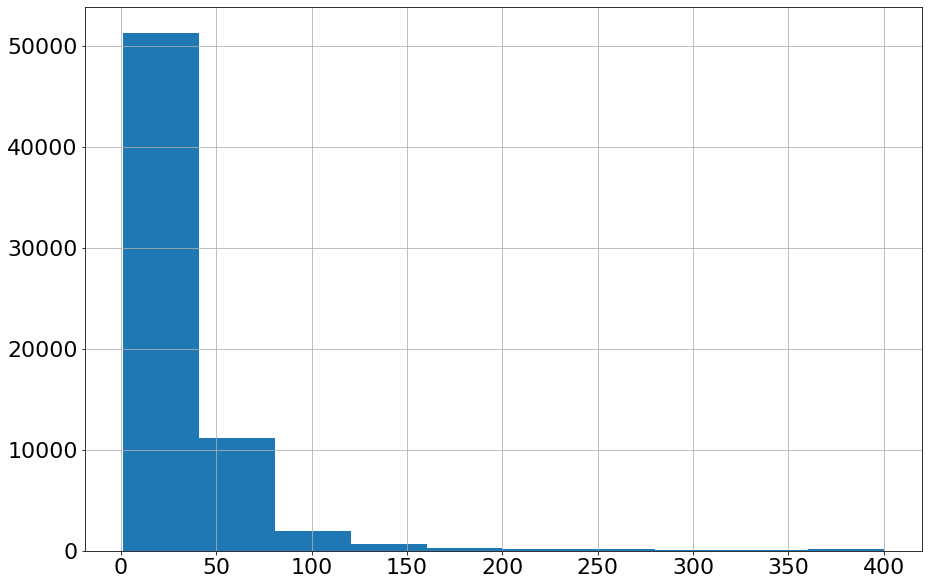

In [ ]:
df['description'].apply(lambda x: len(x.split())).hist(figsize=(15, 10))

In [ ]:
# 83 примера из 1 слова
df['description'][df['description'].apply(lambda x: True if len(x.split()) == 1 else False)]

237                                                   test
429                                                   тест
703                                                   test
948                                                   тест
1773                                                  test
                               ...                        
11746                                          Согласовано
11981                                          Согласовано
12855                                          Согласовано
16507    2082820829208389858109361123130424012029769509...
17545                                          Согласовано
Name: description, Length: 83, dtype: object

In [ ]:
# убираем mm_ssd т.к. ее больше не существует
df = df[df['team_direct'] != 'MM_SD']

In [ ]:
# меняем названия колонок под huggin face
df.columns = ['description', 'labels']
df

,description,labels
0,"сим-карты получены В данный момент, запросил д...",Disp
1,Гарнитура предоставлена Здравствуйте. Прошу пр...,IT
2,Доступ в продуктивную базу SAP Прошу дать дост...,Access
3,Программа загрузки ОЗМ скорректирована. Поиск ...,MDM
4,Учетная запись создана: r.skorkin@agroinvest.c...,IT
...,...,...
21302,оплата пайщикам ФИО*: Шевцова Марина Владимиро...,RE_FX
21303,"Добрый день, прошу выслать Логин и пароль САП ...",Access
21304,Прошу выслать актуальный пароль СМД [https:/...,Access
21305,Согласовано Добрый день! Просим согласовать з...,MDM


In [ ]:

from sklearn import preprocessing
Label_encoder = preprocessing.LabelEncoder()
Label_encoder.fit(df['labels'])
Label_encoder.classes_

array(['1C', 'ARM', 'Access', 'CO', 'DMS', 'Directum', 'Disp', 'FI_FM',
       'HCM', 'IT', 'ITTelematic', 'MDM', 'MM', 'Novatech', 'PM', 'PP',
       'RE_FX', 'SD'], dtype=object)

In [ ]:
df['labels'] = Label_encoder.fit_transform(df['labels'])

<ipython-input-39-0f55a7c08fa3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = Label_encoder.fit_transform(df['labels'])


In [ ]:
df

,description,labels
0,"сим-карты получены В данный момент, запросил д...",6
1,Гарнитура предоставлена Здравствуйте. Прошу пр...,9
2,Доступ в продуктивную базу SAP Прошу дать дост...,2
3,Программа загрузки ОЗМ скорректирована. Поиск ...,11
4,Учетная запись создана: r.skorkin@agroinvest.c...,9
...,...,...
21302,оплата пайщикам ФИО*: Шевцова Марина Владимиро...,16
21303,"Добрый день, прошу выслать Логин и пароль САП ...",2
21304,Прошу выслать актуальный пароль СМД [https:/...,2
21305,Согласовано Добрый день! Просим согласовать з...,11


In [ ]:
# сохраняем
df.to_csv('df_updated_2021.csv', index=False)

In [ ]:
np.save('classes.npy', Label_encoder.classes_)

In [ ]:
# перемешиваем и рабиваем на train test
df = df.sample(frac=1).reset_index(drop=True)
train = df[:int(len(df)*0.8)]
test =  df[int(len(df)*0.8):]

In [ ]:
len(train), len(test)

(52088, 13023)

In [ ]:
# проверяем что кол-во классов всего df == кол-ву классов train
print(len(train['labels'].value_counts()))
train

18


,description,labels
0,Материал добавлен: 1000060618 01.06.2021 1005...,11
1,Добрый день. Необходима консультация по 45* за...,12
2,Сотрудник заходил под старой учётной записью. ...,13
3,Где необходимо поменять подписанта? Добрый ден...,7
4,Интернет Добрый день.Неполадки с интернет подк...,9
...,...,...
52083,Добрый день! Группа изменена 100585 Ремни Ремн...,11
52084,расширить делового партнера ФИО*: Калагарцева ...,11
52085,1000057955 29.03.2021 100531011 ШТ 70-2409027 ...,11
52086,"Добрый день, команда ""Руднянский Хлеб"" создано...",9


In [ ]:
# проверяем что кол-во классов всего df == кол-ву классов test
print(len(test['labels'].value_counts()))

18


In [ ]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [ ]:
model_name = "sberbank-ai/sbert_large_nlu_ru"

tokenizer = AutoTokenizer.from_pretrained(model_name)
# если есть желание дообучить лучшую модель - оставить эту строчку кода, иначе убрать
# model_name = 'sber-80(-84)'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=18)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# for param in model.bert.parameters():
#     param.requires_grad = False

# for param in model.bert.embeddings.parameters():
#     param.requires_grad = True

In [ ]:
names = list(model.named_parameters())
names[:6]

[('bert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0606, -0.0615,  0.0168,  ..., -0.0138, -0.0484, -0.0585],
          [ 0.0038, -0.0852,  0.0023,  ..., -0.0053,  0.0156, -0.0284],
          [ 0.0240, -0.0408, -0.0073,  ..., -0.0014,  0.0304,  0.0227],
          ...,
          [ 0.0440, -0.0153,  0.0383,  ..., -0.0643, -0.0344, -0.0135],
          [ 0.0465, -0.0162,  0.0522,  ..., -0.0459,  0.0222, -0.0480],
          [ 0.0326,  0.0194,  0.0508,  ...,  0.0417, -0.0545, -0.0163]],
         device='cuda:0', requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[ 3.9556e-04,  1.1412e-02, -7.9491e-03,  ..., -2.6713e-04,
           -3.0242e-03, -1.2221e-02],
          [-4.3789e-03,  8.2686e-03,  7.2317e-03,  ...,  5.0034e-03,
            2.9022e-03,  1.4276e-03],
          [ 5.3956e-03,  2.1844e-02,  1.8691e-02,  ..., -1.1598e-03,
           -3.7614e-03, -3.7767e-05],
          ...,
          [-4.0377e-03, -8.1

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

28630

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [ ]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Using custom data configuration default-c716c783a19492d1
Reusing dataset csv (C:\Users\tixon\.cache\huggingface\datasets\csv\default-c716c783a19492d1\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


In [ ]:
dataset = dataset.map(lambda e: tokenizer(e['description'], truncation = True, max_length=100, padding='max_length'), batched=True)

Loading cached processed dataset at C:\Users\tixon\.cache\huggingface\datasets\csv\default-c716c783a19492d1\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0\cache-7e1df1bce8bed17b.arrow
Loading cached processed dataset at C:\Users\tixon\.cache\huggingface\datasets\csv\default-c716c783a19492d1\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0\cache-6317354144cdf1fa.arrow


In [ ]:
# это стандартные колонки для формата пайторча, все кроме них убираем
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  # 
# убираем их из загрузчика
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns))) 

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 52088
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'token_type_ids'],
        num_rows: 13023
    })
})

In [ ]:
# переврдим в формат пайторча
# сразу грузим на gpu, если есть cuda, иначе девайс стоит убрать из аргумента
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda') 
# dataset.set_format(type='torch', columns="input_ids", device='cuda') 

In [ ]:
# установить 8 или больше, если более 16 гб видеопамяти
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=1)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=1)

In [ ]:
len(train_dataloader)

52088

In [ ]:
# оптимизатор AdamW, лр стоит поперебирать
optimizer = AdamW(model.parameters(), lr=2e-6)
# количество эпох можно побольше поставить
num_epochs = 4
# количество шагов
num_training_steps = num_epochs * len(train_dataloader)

# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import gc
gc.collect()

26

In [ ]:
next(iter(train_dataloader))

{'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0]], device='cuda:0'),
 'input_ids': tensor([[  101, 10858, 12047,  2945,   113, 90569,   660,  6980,   197, 61712,
          39958,   121, 15718,  1684,   385, 25165,   121, 17562, 65136, 10239,
          14927, 67436,   378,   689,  2233,  8740, 62173,  5397,   102,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,  

In [ ]:
# лучший f1, по нему будем сохранять
best_f1 = 0.
# будем отображать каждые 10% эпохи
show_train_loss_every_num_epoch = 0.1

# проходимся по всем эпохам
for epoch in range(num_epochs):
    # отображаем номера эпох
    print(40*'-', '\nepoch', epoch+1)
    # переводим в режим тренировки
    model.train()
    # смотрим на средний лосс за 10% эпохи
    losses = []
    # итерируемся по треин части 
    for i, batch in enumerate(train_dataloader):
        
        # переводим в режим тренировки
        model.train()
        # print(batch)
        # переносим батч на гпу, где и модель
        batch = {k: v.to(device) for k, v in batch.items()}
        # print(batch)
        # получаем прогнозы
        outputs = model(**batch)
        # print(outputs)
        # получаем лосс встроенный вместе с моделью (кросс-энтропия)
        loss = outputs.loss
        # делаем обратный проход
        loss.backward()
        # шаг по градиенту
        optimizer.step()
        # шаг по скорости
        lr_scheduler.step()
        # шаг по оптимизатору
        optimizer.zero_grad()
        # фиксируем потери на треин
        losses.append(loss.item())
        # отображаем каждый 10% эпохи
        if i%int(len(train_dataloader)*show_train_loss_every_num_epoch)==int(len(train_dataloader)*show_train_loss_every_num_epoch)-1:
            print(f'train loss [{i*100/len(train_dataloader):.2f}%]: {np.array(losses).mean():.3f}')
            losses = []
            # валидируемся в конце эпохи
            print('\nvalidating')
            # загружаем все основные метрики
            f1 = load_metric('f1')
            acc = load_metric('accuracy')
            precision = load_metric('precision')
            recall = load_metric('recall')
            with torch.no_grad():
                # переводим в режим валидации
                model.eval()
                # проходимся по всем батчам из теста
                for batch in tqdm(test_dataloader):
                    # переносим их на гпу
                    batch = {k: v.to(device) for k, v in batch.items()}
                    # не обновляя параметры получаем прогнозы
                    with torch.no_grad():
                        outputs = model(**batch)
                    # получаем сразу логиты
                    logits = outputs.logits
                    # находим верный ответ
                    predictions = torch.argmax(logits, dim=-1)
                    # логируем в метрики по f1
                    f1.add_batch(predictions=predictions, references=batch["labels"])    
                    acc.add_batch(predictions=predictions, references=batch["labels"])    
                    precision.add_batch(predictions=predictions, references=batch["labels"])    
                    recall.add_batch(predictions=predictions, references=batch["labels"])    
                # находим взвешенные по кол-ву примеров на тест метрики
                print('weighted summary:')
                print('Test acc:', acc.compute()['accuracy'])
                print('Test precision:', precision.compute(average = 'weighted')['precision'])
                print('Test recall:', recall.compute(average = 'weighted')['recall'])
                f1_weighted = f1.compute(average = 'weighted')['f1']
                print('Test f1:', f1_weighted, '\n')
                # если текущая f1 лучше максимальной
                if f1_weighted > best_f1:
                    # максмальная становится текущей
                    best_f1 = f1_weighted
                    # сохраняем модель
                    model.save_pretrained(f"best_model_nov_2021_f1_max={best_f1}_len=100")

    # переводим обратно в режим тренировки для следующей эпохи
    model.train()

---------------------------------------- 
epoch 1


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 8.00 GiB total capacity; 6.58 GiB already allocated; 0 bytes free; 6.59 GiB reserved in total by PyTorch)

In [ ]:
# np.save('classes.npy', Label_encoder.classes_)
Label_encoder = preprocessing.LabelEncoder()

# для того, чтобы восстановить кодировку целевых признаков как при обучении
Label_encoder.classes_ = np.load('classes.npy', allow_pickle=True)

# валидируем по тесту
# реальные ответы и предсказания
true = []
preds = []

# переводим модель в режим инференса
model.eval()
# проходимся по батчам теста
for batch in tqdm(test_dataloader):
    # переносим батч на GPU
    batch = {k: v.to(device) for k, v in batch.items()}
    # без обновления параметров находим прогнозы
    with torch.no_grad():
        outputs = model(**batch)
    # получаем логиты
    logits = outputs.logits
    # из логитов прогноз
    predictions = torch.argmax(logits, dim=-1)
    # добавляем пачки ответов и прогнозов в массивы
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

# ковертируем ответы и прогнозы обратно в человеко-читаемые названия классов, смотрим report по всем метрикам по каждому классу
print(classification_report(Label_encoder.inverse_transform(true), Label_encoder.inverse_transform(preds)))

100%|██████████████████████████████████████████████████████████████████████████████| 8972/8972 [14:04<00:00, 10.62it/s]

              precision    recall  f1-score   support

          1C       0.50      0.47      0.49       121
         ARM       0.58      0.51      0.54        93
      Access       0.90      0.90      0.90       849
          CO       0.76      0.62      0.68        45
         DMS       0.84      0.75      0.79       172
    Directum       0.84      0.72      0.78       159
        Disp       0.50      0.44      0.47       537
       FI_FM       0.79      0.85      0.82       508
         HCM       0.84      0.92      0.88       712
          IT       0.85      0.86      0.86      2065
 ITTelematic       0.96      0.95      0.95       294
         MDM       0.97      0.98      0.97      2646
          MM       0.53      0.48      0.50       185
       MM_SD       0.48      0.51      0.50        61
    Novatech       0.89      0.86      0.87        97
          PM       0.84      0.73      0.78       110
          PP       0.65      0.73      0.69       213
       RE_FX       0.61    